In [3]:
import tensorflow as tf
import random
from glob import glob
from skimage import img_as_float32
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio.v2 as imageio
from sklearn.metrics import accuracy_score, f1_score

In [4]:
def get_test():

    ''' Reading in, splitting and putting testing data into a tensorflow dataset '''

    def split(imgs, msks, seed=42):
        random.seed(seed)
        c = list(zip(imgs, msks))
        random.shuffle(c)
        imgs, msks = zip(*c)

        train = 34
        val = 7
        test = 7

        x_train, y_train = imgs[:train], msks[:train]
        x_val, y_val = imgs[train:train+val], msks[train:train+val]
        x_test, y_test = imgs[-1*test:], msks[-1*test:]

        return x_train, y_train, x_val, y_val, x_test, y_test

    path_pairs = list(zip(
    natsorted(glob('./puzzle_corners_1024x768/images-1024x768/*.png')),
    natsorted(glob('./puzzle_corners_1024x768/masks-1024x768/*.png')),
    ))

    imgs = np.array([cv2.resize(img_as_float32(imageio.imread(ipath)), (192, 256)) for ipath, _ in path_pairs])
    msks = np.array([cv2.resize(img_as_float32(imageio.imread(mpath)), (192, 256)) for _, mpath in path_pairs])

    _, _, _, _, x_test, y_test = split(imgs, msks)

    test_data = tf.data.Dataset.from_tensor_slices((

            {
                'x' : np.expand_dims(x_test, axis=0)
            },
            {
                'y' : tf.one_hot(np.expand_dims(y_test, axis=0), depth=2, dtype=tf.int32)
            }
        )
    )

    return test_data, y_test

savedir = './model'

# Reading in model
model = tf.keras.models.load_model(savedir)
test, msks = get_test()

In [ ]:
model.summary()

In [5]:
# Performing predictions on entire test set

preds = model.predict(test)
preds = [np.argmax(i, axis=-1).astype(np.float32) for i in preds]

1/1 [==============================] - 3s 3s/step


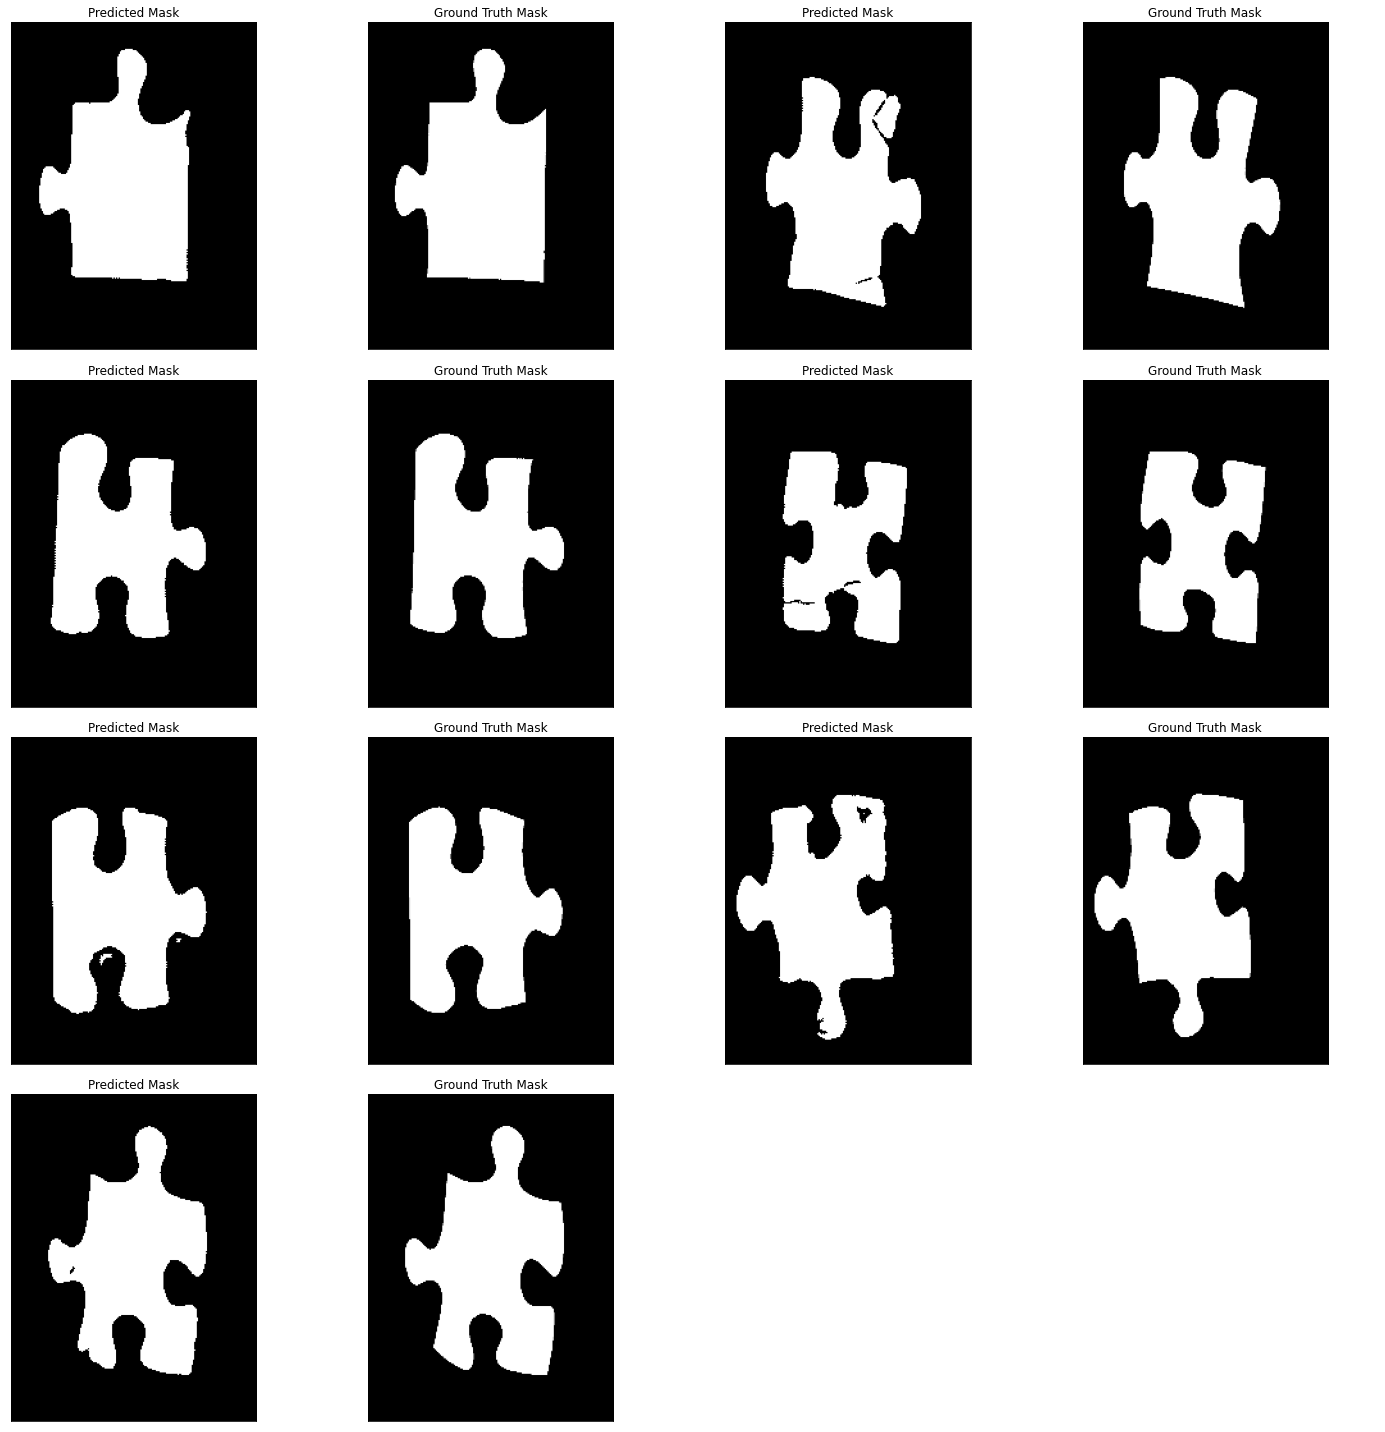

In [25]:
# Generating the plots seen in Appendix C in the report


fig, axs = plt.subplots(4, 4, figsize=(20, 20), facecolor='white')
ax = axs.ravel()

try:
    for i in range(0, 15, 2):
        ax[i].imshow(preds[i//2], cmap='gray')
        ax[i].set_title('Predicted Mask')
        ax[i].set_xticks([])
        ax[i].set_yticks([])

        ax[i+1].imshow(msks[i//2], cmap='gray')
        ax[i+1].set_title('Ground Truth Mask')
        ax[i+1].set_xticks([])
        ax[i+1].set_yticks([])
except:
    ax[-2].axis('off')
    ax[-1].axis('off')
fig.tight_layout()
plt.show()

In [ ]:
for pred, mask in zip(preds, msks):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(pred, cmap='gray')
    axs[0].set_title("Prediction")
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Ground Truth")

    plt.show()

In [ ]:
# Calculating average precision

i = 0
t_f1 = 0
t_acc = 0
for pred, mask in zip(preds, msks):
    acc = accuracy_score(mask.flatten().round(), pred.flatten().round())
    t_acc += acc
    f1 = f1_score(mask.flatten().round(), pred.flatten().round())
    t_f1 += f1
    i += 1
    print(f"Prediction {i}:\nAccuracy score: {acc*100:.2f}%\t F1 score: {f1*100:.2f}%\n")

print(f"Average accuracy score: {t_acc/i * 100:.2f}%")
print(f"Average F1 score: {t_f1/i * 100:.2f}%")
